# Purpose:
- address random seed issue in mfishtools
- Develop mfishtoolspy to iterate multiple times for one gene addition
- Make code more stable for addressing 'other' genes

In [82]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from importlib import reload
import datetime
from glob import glob
import json

import sys
sys.path.append(r'C:\Users\jinho.kim\Github\lamf_analysis_lims\gene_panel_selection\mfishtoolspy')
import mfishtools


In [84]:
# options for cluster grouping
ops = {
    # 'panel_name': 'Pan-neuronal', # GABAergic or Glutamatergic or Pan-neuronal
    'panel_name': 'GABAergic', # GABAergic or Glutamatergic or Pan-neuronal
    'full_panel_size': 28,
    'starting_genes': ["Gad2","Slc17a7","Pvalb","Sst","Vip","Cck","Tac1","Npy","Crh","Necab1","Ptprt","Kirrel3","Penk","Hpse","Calb2","Chodl"],
    'layer_1234_filter': True,
    'GABAergic_group_level': 'cluster', # class, subclass, supertype, or cluster
    'GABAergic_mapping_level': 'cluster',
    'Glutamatergic_group_level': 'subclass', # class, subclass, supertype, or cluster
    'Glutamatergic_mapping_level': 'subclass',
    'GABAergic_other_group_level': 'class', # class, subclass, supertype, or cluster
    'GABAergic_other_mapping_level': 'cluster',
    'Glutamatergic_other_group_level': 'class', # class, subclass, supertype, or cluster
    'Glutamatergic_other_mapping_level': 'subclass',
    'blend_supertypes': False,  # Don't know if I'm going to keep this
    'remove_redundant_genes': False, # from the starting_genes list
    'remove_redundant_genes_threshold': 0.95, # threshold for removing redundant genes from normalized accuracy
    'L1234_layer_threshold': 0.15,
    'L6_layer_threshold': 0.7,
    'L1234_labels': ['L1', 'L1-L2/3', 'L1-L4', 'L2/3', 'L2/3-L4', 'L4'],
    'L6_labels': ['L6', 'L6b'],
    'max_on': 5000,
    'max_off': 1129,
    'min_on': 10,
    'max_fraction_on_clusters': 0.5,
    'num_subsample': 50,
    
}

if 'GABAergic' in ops['panel_name']:
    ops['keep_class'] = ['GABAergic']
elif 'Glutamatergic' in ops['panel_name']:
    ops['keep_class'] = ['Glutamatergic']
elif 'Pan-neuronal' in ops['panel_name']:
    ops['keep_class'] = ['GABAergic', 'Glutamatergic']
else:
    raise ValueError('panel_name must be GABAergic, Glutamatergic, or Pan-neuronal')

level_hierarchy = {'class': 0, 'subclass': 1, 'supertype': 2, 'cluster': 3}
assert level_hierarchy[ops['GABAergic_group_level']] <= level_hierarchy[ops['GABAergic_mapping_level']]
assert level_hierarchy[ops['GABAergic_other_group_level']] <= level_hierarchy[ops['GABAergic_other_mapping_level']]
assert level_hierarchy[ops['Glutamatergic_group_level']] <= level_hierarchy[ops['Glutamatergic_mapping_level']]
assert level_hierarchy[ops['Glutamatergic_other_group_level']] <= level_hierarchy[ops['Glutamatergic_other_mapping_level']]




In [67]:
# paths to the data
data_folder = Path(r'\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\data\mouse_VISp_gene_expression_matrices_2018-06-14')
output_folder = Path(r'\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\results')

In [66]:
print(output_folder)

\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\inhibitory


In [5]:
# read annotation
annotation = pd.read_feather(data_folder / 'anno.feather')
# read data
# TODO: check where this data is coming from. Values are similar to cpm but not exactly the same
cpm_data = pd.read_feather(data_folder / 'exon_cpm.feather')
tpm_data = pd.read_feather(data_folder / 'exon_tpm.feather')

In [6]:
annotation.set_index('sample_id', inplace=True, drop=True)
# data.set_index('gene', inplace=True, drop=True) # only necessary with data_t.feather

In [9]:
# preprocessing
# Removing 'X" in column? from Hannah's code. Don't know when this happens, but leave them here just in case.
if 'X' in cpm_data.columns:
    print('Dropping "X" column from data')
    cpm_data = cpm_data.drop(columns=['X'])
if 'X' in tpm_data.columns:
    print('Dropping "X" column from data')
    tpm_data = tpm_data.drop(columns=['X']) 
if 'X' in annotation.columns:
    print('Dropping "X" column fro annotation')
    annotation = annotation.drop(columns=['X'])

# change the row order of annotation to match the order of columns in data
# annotation = annotation.loc[data.columns]  # don't need this, but add assert statement to check
assert np.all(annotation.index.values == tpm_data.columns.values)
assert np.all(annotation.index.values == cpm_data.columns.values)

In [10]:
# data conversion to log2
tpm_log2 = np.log2(tpm_data + 1)
cpm_log2 = np.log2(cpm_data + 1)

In [11]:
# read supertype information
# TODO: re-define supertype (will be addressed in another notebook)
supertype_folder = Path('//allen/programs/mindscope/workgroups/omfish/hannahs/mfish_project/gene_panels')
supertype_fn = supertype_folder / 'tasic2018_supertypes_manual_v2.xlsx'
sheet_name = 'all_supertypes_v2'
supertype = pd.read_excel(supertype_fn, sheet_name=sheet_name)
supertype.rename(columns={'Cell Type': 'cell_type', 'Supertype': 'supertype'}, inplace=True)
supertype.cell_type = supertype.cell_type.str.replace('\xa0', ' ')
supertype.supertype = supertype.supertype.str.replace('\xa0', ' ')
assert np.all([ct in annotation['cluster_label'].values for ct in supertype.cell_type.values])
supertype.set_index('cell_type', inplace=True, drop=True)

annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_30952\765796578.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)


In [12]:
annotation.query('class_label=="Glutamatergic"').supertype_label.unique()

array(['L4 IT VISp', 'L2/3 IT VISp', 'L5 NP VISp Trhr ',
       'L5 IT VISp Batf3', 'L6 CT VISp Ctxn3', 'L6 IT VISp Penk',
       'L6 IT VISp Car3', 'L5 IT VISp Col6a1', 'L5 PT VISp C1ql2',
       'L6b P2ry12', 'L6 CT VISp Gpr139', 'L6b VISp Col8a1 ',
       'L5 PT VISp Chrna6', 'CR Lhx5', 'L6b Hsd17b2'], dtype=object)

In [13]:
annotation.query('class_label=="GABAergic"').subclass_label.unique()

array(['Pvalb', 'Vip', 'Lamp5', 'Sst', 'Sncg', 'Serpinf1', 'Meis2'],
      dtype=object)

In [14]:
group_label = f'{ops["Glutamatergic_group_level"]}_label'
mapping_label = f'{ops["Glutamatergic_mapping_level"]}_label'
temp_annotation = annotation.query('class_label=="Glutamatergic"')

In [85]:
# filtering and assigning group_label
# Group means target clustering that I want to classify eventually
# There is also mapping_label, to which I want to match first before calculating classification accuracy
# E.g., match individual samples to cluster level but then classify them at supertype level
# E.g., classification can happen in mixed level, some at the cluster level while others in subclass level

# If "other" group and mapping levels are different from group and mapping levels
# then assign relevant labels to "other" group and mapping levels
#   "other" is relevant only when filtering by the layers
#   It means the rest of groups of mappings that can be within the imaging regime but we want to exclude from further analysis

# Filtering based on layer abundance
# TODO: test thresholds. 
# TODO: Better to do this from merFISH data

keep_groups = []
keep_mappings = []
other_groups = []
other_mappings = []

if 'Glutamatergic' in ops['keep_class']:
    # Assign group and mapping labels
    group_level_label = f'{ops["Glutamatergic_group_level"]}_label'
    group_label_list = [f'Glutamatergic {gl}' for gl in annotation.loc[annotation.class_label == 'Glutamatergic', group_level_label]] # To disambiguate from GABAergic groups
    annotation.loc[annotation.class_label == 'Glutamatergic', 'group_label'] = group_label_list
    mapping_level_label = f'{ops["Glutamatergic_mapping_level"]}_label'
    mapping_label_list = [f'Glutamatergic {ml}' for ml in annotation.loc[annotation.class_label == 'Glutamatergic', mapping_label]] # To disambiguate from GABAergic mappings
    annotation.loc[annotation.class_label == 'Glutamatergic', 'mapping_label'] = mapping_label_list
    
    # Assign keep and other groups.
    # If lower than class level, then consider layer filtering (L1234 only for now)
    if ops['Glutamatergic_group_level'] == 'class':
        keep_groups += ['Glutamatergic']
    else:
        temp_annotation = annotation.query('class_label=="Glutamatergic"')
        if ops['layer_1234_filter']:
            keep_groups += [gl for gl in temp_annotation['group_label'].unique().tolist() if gl.split(' ')[1] in ['L2/3', 'L4']] # Have class label at the beginning
            # Process "other" groups
            other_group_level_label = f'{ops["Glutamatergic_other_group_level"]}_label'
            temp_other_groups = [gl for gl in temp_annotation['group_label'].unique().tolist() if gl.split(' ')[1] in ['L5', 'NP']] # Have class label at the beginning
            if other_group_level_label == group_level_label: # no need to change group labels
                other_groups += temp_other_groups
            else:
                # Add L5 after class label
                other_group_labels = [f'Glutamatergic L5 {gl}' for gl in annotation[annotation['group_label'].isin(temp_other_groups)][other_group_level_label].values]
                annotation.loc[annotation['group_label'].isin(temp_other_groups), 'group_label'] = other_group_labels
                other_groups += np.unique(other_group_labels).tolist()
        else:
            keep_groups += temp_annotation['group_label'].unique().tolist()
    # Assign keep and other mappings.
    if ops['Glutamatergic_mapping_level'] == 'class':
        keep_mappings += ['Glutamatergic']
    else:
        temp_annotation = annotation.query('class_label=="Glutamatergic"')
        if ops['layer_1234_filter']:
            keep_mappings += [ml for ml in temp_annotation['mapping_label'].unique().tolist() if ml.split(' ')[1] in ['L2/3', 'L4']] # Have class label at the beginning
            # Process "other" groups
            other_mapping_level_label = f'{ops["Glutamatergic_other_mapping_level"]}_label'
            temp_other_mappings = [ml for ml in temp_annotation['mapping_label'].unique().tolist() if ml.split(' ')[1] in ['L5', 'NP']] # Have class label at the beginning
            if other_mapping_level_label == mapping_level_label: # no need to change mapping labels
                other_mappings += temp_other_mappings
            else:
                # Add L5 after class label
                other_mapping_labels = [f'Glutamatergic L5 {ml}' for ml in annotation[annotation['mapping_label'].isin(temp_other_mappings)][other_mapping_level_label].values]
                annotation.loc[annotation['mapping_label'].isin(temp_other_mappings), 'mapping_label'] = other_mapping_labels
                other_mappings += np.unique(other_mapping_labels).tolist()
        else:
            keep_mappings += temp_annotation['mapping_label'].unique().tolist()

# Same for GABAergic
# Except for filtering, now we are using scRNAseq layer-enriched data with thresholds
if 'GABAergic' in ops['keep_class']:
    # Assign group and mapping labels
    group_level_label = f'{ops["GABAergic_group_level"]}_label'
    group_label_list = [f'GABAergic {gl}' for gl in annotation.loc[annotation.class_label == 'GABAergic', group_level_label]] # To disambiguate from Glutamatergic groups
    annotation.loc[annotation.class_label == 'GABAergic', 'group_label'] = group_label_list
    mapping_level_label = f'{ops["GABAergic_mapping_level"]}_label'
    mapping_label_list = [f'GABAergic {ml}' for ml in annotation.loc[annotation.class_label == 'GABAergic', mapping_level_label]] # To disambiguate from Glutamatergic mappings
    annotation.loc[annotation.class_label == 'GABAergic', 'mapping_label'] = mapping_label_list
    
    # Assign keep and other groups.
    # If lower than class level, then consider layer filtering (L1234 only for now)
    # Also need to name them different (adding L5 in front of the group and mapping labels)
    if ops['GABAergic_group_level'] == 'class':
        keep_groups += ['GABAergic']
    else:
        temp_annotation = annotation.query('class_label=="GABAergic"')
        if ops['layer_1234_filter']:
            # Filtering process based on the layer abundance
            layer_df = annotation.query('class_label=="GABAergic"')[['layer_label', 'cluster_label']].copy()
            layer_table = layer_df.groupby(['layer_label', 'cluster_label']).size().unstack(fill_value=0)
            prop_table = layer_table.div(layer_table.sum(axis=0), axis=1)
            L1234_prop_sum = prop_table.loc[ops['L1234_labels']].sum(axis=0)
            L1234_inh_types = set(L1234_prop_sum[L1234_prop_sum >= ops['L1234_layer_threshold']].index.values)
            not_L1234_inh_types = set(layer_df.cluster_label).difference(L1234_inh_types)
            L6_prop_sum = prop_table.loc[ops['L6_labels']].sum(axis=0)
            L6_inh_types = set(L6_prop_sum[L6_prop_sum >= ops['L6_layer_threshold']].index.values)
            L5_inh_types = not_L1234_inh_types.difference(L6_inh_types)
            # L1234_inh_types are going to be kept
            # L5_inh_types are going to be "other"
            # Ignore L6_inh_types (assume they won't be imaged)
            keep_annotation = temp_annotation[temp_annotation['cluster_label'].isin(L1234_inh_types)]
            other_annotation = temp_annotation[temp_annotation['cluster_label'].isin(L5_inh_types)]
            
            keep_groups += keep_annotation['group_label'].unique().tolist()

            # Process "other" groups
            other_group_level_label = f'{ops["GABAergic_other_group_level"]}_label'
            temp_other_groups = other_annotation['group_label'].unique().tolist()
            if other_group_level_label == group_level_label: # no need to change group labels
                other_groups += temp_other_groups
            else:
                # Add L5 after class label
                other_group_labels = [f'GABAergic L5 {gl}' for gl in annotation[annotation['group_label'].isin(temp_other_groups)][other_group_level_label].values]
                annotation.loc[annotation['group_label'].isin(temp_other_groups), 'group_label'] = other_group_labels
                other_groups += np.unique(other_group_labels).tolist()
        else:
            keep_groups += temp_annotation['group_label'].unique().tolist()
    # Assign keep and other mappings.
    if ops['GABAergic_mapping_level'] == 'class':
        keep_mappings += ['GABAergic']
    else:
        temp_annotation = annotation.query('class_label=="GABAergic"')
        if ops['layer_1234_filter']:
            # Filtering process should have been done already in the above if clause
            # keep_annotation and other_annotation are already defined
            keep_mappings += keep_annotation['mapping_label'].unique().tolist()
            
            # Process "other" groups
            other_mapping_level_label = f'{ops["GABAergic_other_mapping_level"]}_label'
            temp_other_mappings = other_annotation['mapping_label'].unique().tolist()
            if other_mapping_level_label == mapping_level_label: # no need to change mapping labels
                other_mappings += temp_other_mappings
            else:
                # Add L5 after class label
                other_mapping_labels = [f'GABAergic L5 {ml}' for ml in annotation[annotation['mapping_label'].isin(temp_other_mappings)][other_mapping_level_label].values]
                annotation.loc[annotation['mapping_label'].isin(temp_other_mappings), 'mapping_label'] = other_mapping_labels
                other_mappings += np.unique(other_mapping_labels).tolist()
        else:
            keep_mappings += temp_annotation['mapping_label'].unique().tolist()

# assign cluster to nan mapping labels
# for filtering using "off clusters" information (e.g., glial cells)
annotation.loc[annotation['mapping_label']=='nan', 'mapping_label'] = annotation.loc[annotation['mapping_label']=='nan', 'cluster_label'] 

In [86]:
ops['keep_mappings'] = keep_mappings
ops['other_mappings'] = other_mappings
ops['keep_groups'] = keep_groups
ops['other_groups'] = other_groups

## Validation
- Done with 'Pan-neuronal' setting

In [280]:
L23_exc = annotation[(annotation.class_label=="Glutamatergic") & annotation.cluster_label.str.startswith('L2/3')]
L23_exc[['class_label', 'cluster_label', 'group_label', 'mapping_label']]

,class_label,cluster_label,group_label,mapping_label
sample_id,,,,
LS-14690_S11_E1-50,Glutamatergic,L2/3 IT VISp Agmat,Glutamatergic L2/3 IT,Glutamatergic L2/3 IT VISp Agmat
LS-14692_S01_E1-50,Glutamatergic,L2/3 IT VISp Agmat,Glutamatergic L2/3 IT,Glutamatergic L2/3 IT VISp Agmat
LS-14696_S33_E1-50,Glutamatergic,L2/3 IT VISp Adamts2,Glutamatergic L2/3 IT,Glutamatergic L2/3 IT VISp Adamts2
LS-14696_S34_E1-50,Glutamatergic,L2/3 IT VISp Agmat,Glutamatergic L2/3 IT,Glutamatergic L2/3 IT VISp Agmat
LS-14696_S35_E1-50,Glutamatergic,L2/3 IT VISp Agmat,Glutamatergic L2/3 IT,Glutamatergic L2/3 IT VISp Agmat
...,...,...,...,...
SM-GE8ZO_S094_E1-50,Glutamatergic,L2/3 IT VISp Agmat,Glutamatergic L2/3 IT,Glutamatergic L2/3 IT VISp Agmat
SM-GE8ZO_S095_E1-50,Glutamatergic,L2/3 IT VISp Adamts2,Glutamatergic L2/3 IT,Glutamatergic L2/3 IT VISp Adamts2
SM-GE8ZO_S096_E1-50,Glutamatergic,L2/3 IT VISp Adamts2,Glutamatergic L2/3 IT,Glutamatergic L2/3 IT VISp Adamts2


In [281]:
print(L23_exc.group_label.unique())
print(L23_exc.mapping_label.unique())

['Glutamatergic L2/3 IT']
['Glutamatergic L2/3 IT VISp Agmat' 'Glutamatergic L2/3 IT VISp Adamts2'
 'Glutamatergic L2/3 IT VISp Rrad']


In [282]:
L4_exc = annotation[(annotation.class_label=="Glutamatergic") & annotation.cluster_label.str.startswith('L4')]
L4_exc[['class_label', 'cluster_label', 'group_label', 'mapping_label']]

,class_label,cluster_label,group_label,mapping_label
sample_id,,,,
LS-14690_S03_E1-50,Glutamatergic,L4 IT VISp Rspo1,Glutamatergic L4,Glutamatergic L4 IT VISp Rspo1
LS-14690_S05_E1-50,Glutamatergic,L4 IT VISp Rspo1,Glutamatergic L4,Glutamatergic L4 IT VISp Rspo1
LS-14690_S06_E1-50,Glutamatergic,L4 IT VISp Rspo1,Glutamatergic L4,Glutamatergic L4 IT VISp Rspo1
LS-14690_S07_E1-50,Glutamatergic,L4 IT VISp Rspo1,Glutamatergic L4,Glutamatergic L4 IT VISp Rspo1
LS-14690_S08_E1-50,Glutamatergic,L4 IT VISp Rspo1,Glutamatergic L4,Glutamatergic L4 IT VISp Rspo1
...,...,...,...,...
SM-GE91H_S343_E1-50,Glutamatergic,L4 IT VISp Rspo1,Glutamatergic L4,Glutamatergic L4 IT VISp Rspo1
SM-GE91H_S344_E1-50,Glutamatergic,L4 IT VISp Rspo1,Glutamatergic L4,Glutamatergic L4 IT VISp Rspo1
SM-GE91H_S362_E1-50,Glutamatergic,L4 IT VISp Rspo1,Glutamatergic L4,Glutamatergic L4 IT VISp Rspo1


In [283]:
print(L4_exc.group_label.unique())
print(L4_exc.mapping_label.unique())

['Glutamatergic L4']
['Glutamatergic L4 IT VISp Rspo1']


In [284]:
L5_exc = annotation[(annotation.class_label=="Glutamatergic") & (annotation.cluster_label.str.startswith('L5') | annotation.cluster_label.str.startswith('NP'))]
L5_exc[['class_label', 'cluster_label', 'group_label', 'mapping_label']]

,class_label,cluster_label,group_label,mapping_label
sample_id,,,,
LS-14690_S17_E1-50,Glutamatergic,L5 NP VISp Trhr Cpne7,Glutamatergic L5 Glutamatergic,Glutamatergic L5 NP VISp Trhr Cpne7
LS-14690_S20_E1-50,Glutamatergic,L5 IT VISp Hsd11b1 Endou,Glutamatergic L5 Glutamatergic,Glutamatergic L5 IT VISp Hsd11b1 Endou
LS-14690_S26_E1-50,Glutamatergic,L5 NP VISp Trhr Met,Glutamatergic L5 Glutamatergic,Glutamatergic L5 NP VISp Trhr Met
LS-14690_S30_E1-50,Glutamatergic,L5 NP VISp Trhr Cpne7,Glutamatergic L5 Glutamatergic,Glutamatergic L5 NP VISp Trhr Cpne7
LS-14690_S31_E1-50,Glutamatergic,L5 IT VISp Batf3,Glutamatergic L5 Glutamatergic,Glutamatergic L5 IT VISp Batf3
...,...,...,...,...
SM-GE91H_S364_E1-50,Glutamatergic,L5 IT VISp Col6a1 Fezf2,Glutamatergic L5 Glutamatergic,Glutamatergic L5 IT VISp Col6a1 Fezf2
SM-GE91H_S365_E1-50,Glutamatergic,L5 IT VISp Batf3,Glutamatergic L5 Glutamatergic,Glutamatergic L5 IT VISp Batf3
SM-GE91H_S366_E1-50,Glutamatergic,L5 IT VISp Batf3,Glutamatergic L5 Glutamatergic,Glutamatergic L5 IT VISp Batf3


In [285]:
print(L5_exc.group_label.unique())
print(L5_exc.mapping_label.unique())

['Glutamatergic L5 Glutamatergic']
['Glutamatergic L5 NP VISp Trhr Cpne7'
 'Glutamatergic L5 IT VISp Hsd11b1 Endou'
 'Glutamatergic L5 NP VISp Trhr Met' 'Glutamatergic L5 IT VISp Batf3'
 'Glutamatergic L5 IT VISp Col27a1' 'Glutamatergic L5 PT VISp Krt80'
 'Glutamatergic L5 IT VISp Whrn Tox2'
 'Glutamatergic L5 PT VISp C1ql2 Ptgfr' 'Glutamatergic L5 PT VISp Chrna6'
 'Glutamatergic L5 IT VISp Col6a1 Fezf2'
 'Glutamatergic L5 PT VISp C1ql2 Cdh13' 'Glutamatergic L5 PT VISp Lgr5']


In [286]:
L6_exc = annotation[(annotation.class_label=="Glutamatergic") & annotation.cluster_label.str.startswith('L6')]
L6_exc[['class_label', 'cluster_label', 'group_label', 'mapping_label']]

,class_label,cluster_label,group_label,mapping_label
sample_id,,,,
LS-14690_S34_E1-50,Glutamatergic,L6 CT VISp Ctxn3 Brinp3,Glutamatergic L6 CT,Glutamatergic L6 CT VISp Ctxn3 Brinp3
LS-14690_S35_E1-50,Glutamatergic,L6 IT VISp Penk Col27a1,Glutamatergic L6 IT,Glutamatergic L6 IT VISp Penk Col27a1
LS-14690_S36_E1-50,Glutamatergic,L6 CT VISp Ctxn3 Brinp3,Glutamatergic L6 CT,Glutamatergic L6 CT VISp Ctxn3 Brinp3
LS-14690_S38_E1-50,Glutamatergic,L6 IT VISp Col23a1 Adamts2,Glutamatergic L6 IT,Glutamatergic L6 IT VISp Col23a1 Adamts2
LS-14690_S40_E1-50,Glutamatergic,L6 IT VISp Penk Col27a1,Glutamatergic L6 IT,Glutamatergic L6 IT VISp Penk Col27a1
...,...,...,...,...
SM-GE8ZL_S112_E1-50,Glutamatergic,L6 CT VISp Nxph2 Wls,Glutamatergic L6 CT,Glutamatergic L6 CT VISp Nxph2 Wls
SM-GE8ZL_S176_E1-50,Glutamatergic,L6 IT VISp Penk Col27a1,Glutamatergic L6 IT,Glutamatergic L6 IT VISp Penk Col27a1
SM-GE8ZO_S035_E1-50,Glutamatergic,L6 CT VISp Ctxn3 Brinp3,Glutamatergic L6 CT,Glutamatergic L6 CT VISp Ctxn3 Brinp3


In [287]:
print(L6_exc.group_label.unique())
print(L6_exc.mapping_label.unique())

['Glutamatergic L6 CT' 'Glutamatergic L6 IT' 'Glutamatergic L6b']
['Glutamatergic L6 CT VISp Ctxn3 Brinp3'
 'Glutamatergic L6 IT VISp Penk Col27a1'
 'Glutamatergic L6 IT VISp Col23a1 Adamts2'
 'Glutamatergic L6 IT VISp Col18a1' 'Glutamatergic L6 IT VISp Penk Fst'
 'Glutamatergic L6 IT VISp Car3' 'Glutamatergic L6 CT VISp Ctxn3 Sla'
 'Glutamatergic L6 CT VISp Krt80 Sla' 'Glutamatergic L6b P2ry12'
 'Glutamatergic L6 CT VISp Nxph2 Wls' 'Glutamatergic L6 CT VISp Gpr139'
 'Glutamatergic L6b VISp Mup5' 'Glutamatergic L6b Col8a1 Rprm'
 'Glutamatergic L6 CT Nxph2 Sla' 'Glutamatergic L6b VISp Col8a1 Rxfp1'
 'Glutamatergic L6b VISp Crh' 'Glutamatergic L6b Hsd17b2']


In [288]:
annotation[annotation.class_label=="GABAergic"].group_label.unique()

array(['GABAergic Pvalb Tpbg', 'GABAergic Vip Chat Htr1f',
       'GABAergic Lamp5 Lsp1', 'GABAergic Sst Hpse Sema3c',
       'GABAergic Vip Pygm C1ql1', 'GABAergic Vip Ptprt Pkp2',
       'GABAergic Vip Igfbp4 Mab21l1', 'GABAergic Sst Chodl',
       'GABAergic Lamp5 Ntn1 Npy2r', 'GABAergic Vip Igfbp6 Car10',
       'GABAergic Vip Crispld2 Kcne4', 'GABAergic Vip Igfbp6 Pltp',
       'GABAergic L5 GABAergic', 'GABAergic Pvalb Reln Itm2a',
       'GABAergic Vip Lmo1 Myl1', 'GABAergic Vip Crispld2 Htr2c',
       'GABAergic Lamp5 Plch2 Dock5', 'GABAergic Vip Col15a1 Pde1a',
       'GABAergic Vip Rspo4 Rxfp1 Chat',
       'GABAergic Lamp5 Fam19a1 Tmem182', 'GABAergic Lamp5 Fam19a1 Pax6',
       'GABAergic Vip Arhgap36 Hmcn1', 'GABAergic Sncg Vip Itih5',
       'GABAergic Lamp5 Lhx6', 'GABAergic Sncg Slc17a8',
       'GABAergic Sncg Vip Nptx2', 'GABAergic Pvalb Vipr2',
       'GABAergic Lamp5 Krt73', 'GABAergic Serpinf1 Aqp5 Vip',
       'GABAergic Sst Calb2 Pdlim5', 'GABAergic Sst Nts',
   

In [289]:
annotation[annotation.class_label=="GABAergic"].mapping_label.unique()

array(['GABAergic Pvalb Tpbg', 'GABAergic Vip Chat Htr1f',
       'GABAergic Lamp5 Lsp1', 'GABAergic Sst Hpse Sema3c',
       'GABAergic Vip Pygm C1ql1', 'GABAergic Vip Ptprt Pkp2',
       'GABAergic Vip Igfbp4 Mab21l1', 'GABAergic Sst Chodl',
       'GABAergic Lamp5 Ntn1 Npy2r', 'GABAergic Vip Igfbp6 Car10',
       'GABAergic Vip Crispld2 Kcne4', 'GABAergic Vip Igfbp6 Pltp',
       'GABAergic Vip Gpc3 Slc18a3', 'GABAergic Pvalb Reln Itm2a',
       'GABAergic Vip Lmo1 Myl1', 'GABAergic Vip Crispld2 Htr2c',
       'GABAergic Lamp5 Plch2 Dock5', 'GABAergic Vip Col15a1 Pde1a',
       'GABAergic Pvalb Gabrg1', 'GABAergic Vip Rspo4 Rxfp1 Chat',
       'GABAergic Lamp5 Fam19a1 Tmem182', 'GABAergic Lamp5 Fam19a1 Pax6',
       'GABAergic Sst Chrna2 Ptgdr', 'GABAergic Pvalb Reln Tac1',
       'GABAergic Vip Arhgap36 Hmcn1', 'GABAergic Pvalb Calb1 Sst',
       'GABAergic Sst Rxfp1 Prdm8', 'GABAergic Pvalb Th Sst',
       'GABAergic Sst Nr2f2 Necab1', 'GABAergic Sst Myh8 Etv1 ',
       'GABAergic

In [17]:
keep_groups

['Glutamatergic L4',
 'Glutamatergic L2/3 IT',
 'GABAergic Pvalb Tpbg',
 'GABAergic Vip Chat Htr1f',
 'GABAergic Lamp5 Lsp1',
 'GABAergic Sst Hpse Sema3c',
 'GABAergic Vip Pygm C1ql1',
 'GABAergic Vip Ptprt Pkp2',
 'GABAergic Vip Igfbp4 Mab21l1',
 'GABAergic Sst Chodl',
 'GABAergic Lamp5 Ntn1 Npy2r',
 'GABAergic Vip Igfbp6 Car10',
 'GABAergic Vip Crispld2 Kcne4',
 'GABAergic Vip Igfbp6 Pltp',
 'GABAergic Pvalb Reln Itm2a',
 'GABAergic Vip Lmo1 Myl1',
 'GABAergic Vip Crispld2 Htr2c',
 'GABAergic Lamp5 Plch2 Dock5',
 'GABAergic Vip Col15a1 Pde1a',
 'GABAergic Vip Rspo4 Rxfp1 Chat',
 'GABAergic Lamp5 Fam19a1 Tmem182',
 'GABAergic Lamp5 Fam19a1 Pax6',
 'GABAergic Vip Arhgap36 Hmcn1',
 'GABAergic Sncg Vip Itih5',
 'GABAergic Lamp5 Lhx6',
 'GABAergic Sncg Slc17a8',
 'GABAergic Sncg Vip Nptx2',
 'GABAergic Pvalb Vipr2',
 'GABAergic Lamp5 Krt73',
 'GABAergic Serpinf1 Aqp5 Vip',
 'GABAergic Sst Calb2 Pdlim5',
 'GABAergic Sst Mme Fam114a1',
 'GABAergic Sst Hpse Cbln4',
 'GABAergic Vip Lect1 Oxtr

In [18]:
keep_mappings

['Glutamatergic L4',
 'Glutamatergic L2/3 IT',
 'GABAergic Pvalb Tpbg',
 'GABAergic Vip Chat Htr1f',
 'GABAergic Lamp5 Lsp1',
 'GABAergic Sst Hpse Sema3c',
 'GABAergic Vip Pygm C1ql1',
 'GABAergic Vip Ptprt Pkp2',
 'GABAergic Vip Igfbp4 Mab21l1',
 'GABAergic Sst Chodl',
 'GABAergic Lamp5 Ntn1 Npy2r',
 'GABAergic Vip Igfbp6 Car10',
 'GABAergic Vip Crispld2 Kcne4',
 'GABAergic Vip Igfbp6 Pltp',
 'GABAergic Pvalb Reln Itm2a',
 'GABAergic Vip Lmo1 Myl1',
 'GABAergic Vip Crispld2 Htr2c',
 'GABAergic Lamp5 Plch2 Dock5',
 'GABAergic Vip Col15a1 Pde1a',
 'GABAergic Vip Rspo4 Rxfp1 Chat',
 'GABAergic Lamp5 Fam19a1 Tmem182',
 'GABAergic Lamp5 Fam19a1 Pax6',
 'GABAergic Vip Arhgap36 Hmcn1',
 'GABAergic Sncg Vip Itih5',
 'GABAergic Lamp5 Lhx6',
 'GABAergic Sncg Slc17a8',
 'GABAergic Sncg Vip Nptx2',
 'GABAergic Pvalb Vipr2',
 'GABAergic Lamp5 Krt73',
 'GABAergic Serpinf1 Aqp5 Vip',
 'GABAergic Sst Calb2 Pdlim5',
 'GABAergic Sst Mme Fam114a1',
 'GABAergic Sst Hpse Cbln4',
 'GABAergic Vip Lect1 Oxtr

In [292]:
other_groups

['Glutamatergic L5 Glutamatergic', 'GABAergic L5 GABAergic']

In [293]:
other_mappings

['Glutamatergic L5 NP VISp Trhr Cpne7',
 'Glutamatergic L5 IT VISp Hsd11b1 Endou',
 'Glutamatergic L5 NP VISp Trhr Met',
 'Glutamatergic L5 IT VISp Batf3',
 'Glutamatergic L5 IT VISp Col27a1',
 'Glutamatergic L5 PT VISp Krt80',
 'Glutamatergic L5 IT VISp Whrn Tox2',
 'Glutamatergic L5 PT VISp C1ql2 Ptgfr',
 'Glutamatergic L5 PT VISp Chrna6',
 'Glutamatergic L5 IT VISp Col6a1 Fezf2',
 'Glutamatergic L5 PT VISp C1ql2 Cdh13',
 'Glutamatergic L5 PT VISp Lgr5',
 'GABAergic Vip Gpc3 Slc18a3',
 'GABAergic Pvalb Gabrg1',
 'GABAergic Sst Chrna2 Ptgdr',
 'GABAergic Pvalb Reln Tac1',
 'GABAergic Pvalb Calb1 Sst',
 'GABAergic Sst Rxfp1 Prdm8',
 'GABAergic Pvalb Th Sst',
 'GABAergic Sst Nr2f2 Necab1',
 'GABAergic Sst Myh8 Etv1 ',
 'GABAergic Sst Rxfp1 Eya1',
 'GABAergic Sst Chrna2 Glra3',
 'GABAergic Sst Tac2 Tacstd2',
 'GABAergic Sst Esm1',
 'GABAergic Sst Myh8 Fibin',
 'GABAergic Serpinf1 Clrn1',
 'GABAergic Vip Lmo1 Fam159b',
 'GABAergic Sst Crhr2 Efemp1',
 'GABAergic Sst Tac2 Myh4',
 'GABAergic

In [294]:
assert np.all([og in annotation.group_label.unique() for og in other_groups])
assert np.all([om in annotation.mapping_label.unique() for om in other_mappings])
assert np.all([kg in annotation.group_label.unique() for kg in keep_groups])
assert np.all([km in annotation.mapping_label.unique() for km in keep_mappings])

In [295]:
set(annotation.group_label.unique()).difference(other_groups + keep_groups)

{'GABAergic Sst Crh 4930553C11Rik ',
 'GABAergic Sst Nts',
 'Glutamatergic CR',
 'Glutamatergic L6 CT',
 'Glutamatergic L6 IT',
 'Glutamatergic L6b',
 'nan'}

In [296]:
set(annotation.mapping_label.unique()).difference(other_mappings + keep_mappings)

{'Astro Aqp4',
 'Endo Ctla2a',
 'Endo Cytl1',
 'GABAergic Sst Crh 4930553C11Rik ',
 'GABAergic Sst Nts',
 'Glutamatergic CR Lhx5',
 'Glutamatergic L6 CT Nxph2 Sla',
 'Glutamatergic L6 CT VISp Ctxn3 Brinp3',
 'Glutamatergic L6 CT VISp Ctxn3 Sla',
 'Glutamatergic L6 CT VISp Gpr139',
 'Glutamatergic L6 CT VISp Krt80 Sla',
 'Glutamatergic L6 CT VISp Nxph2 Wls',
 'Glutamatergic L6 IT VISp Car3',
 'Glutamatergic L6 IT VISp Col18a1',
 'Glutamatergic L6 IT VISp Col23a1 Adamts2',
 'Glutamatergic L6 IT VISp Penk Col27a1',
 'Glutamatergic L6 IT VISp Penk Fst',
 'Glutamatergic L6b Col8a1 Rprm',
 'Glutamatergic L6b Hsd17b2',
 'Glutamatergic L6b P2ry12',
 'Glutamatergic L6b VISp Col8a1 Rxfp1',
 'Glutamatergic L6b VISp Crh',
 'Glutamatergic L6b VISp Mup5',
 'Microglia Siglech',
 'OPC Pdgfra Ccnb1',
 'OPC Pdgfra Grm5',
 'Oligo Rassf10',
 'Oligo Serpinb1a',
 'Oligo Synpr',
 'PVM Mrc1',
 'Peri Kcnj8',
 'SMC Acta2',
 'VLMC Osr1 Cd74',
 'VLMC Osr1 Mc5r',
 'VLMC Spp1 Col15a1',
 'VLMC Spp1 Hs3st6'}

# Filtering setting done


# - Now address random seed issue
- Divide on_cluster_mapping and on_cluster_group
    - Filtering is based on mapping labels
- Use on_cluster_mapping for initial mapping, and use on_cluster_group for classification performance calculation
- Iternate multiple times (100) for one gene addition
    - Try multiprocessing

In [19]:

# calculate proportions and medians for mapping labels and for group labels
expr_thresh = 1
# make data_log2 to have another level of columns with matching cluster names per cell ID
tpm_log2_cluster = tpm_log2.copy().T
gene_column_names = list(tpm_log2_cluster.columns)
assert np.all(tpm_log2.columns == annotation.index.values)
# groupby cluster and calculate median and proportion
tpm_log2_cluster['mapping_label'] = annotation['mapping_label']
tpm_log2_cluster['group_label'] = annotation['group_label']
tpm_median_per_mapping = tpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').median().T
tpm_prop_expr_mapping = tpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
tpm_median_per_group = tpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').median().T
tpm_prop_expr_group = tpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
assert np.all(tpm_prop_expr_mapping.index.values == tpm_median_per_mapping.index.values)
assert np.all(tpm_prop_expr_group.index.values == tpm_median_per_group.index.values)
assert np.all(tpm_prop_expr_mapping.index.values == tpm_log2.index.values)
assert np.all(tpm_prop_expr_group.index.values == tpm_log2.index.values)

In [20]:
# calculate proportions and medians for mapping labels and for group labels
expr_thresh = 1
# make data_log2 to have another level of columns with matching cluster names per cell ID
cpm_log2_cluster = cpm_log2.copy().T
gene_column_names = list(cpm_log2_cluster.columns)
assert np.all(cpm_log2.columns == annotation.index.values)
# groupby cluster and calculate median and proportion
cpm_log2_cluster['mapping_label'] = annotation['mapping_label']
cpm_log2_cluster['group_label'] = annotation['group_label']
cpm_median_per_mapping = cpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').median().T
cpm_prop_expr_mapping = cpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
cpm_median_per_group = cpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').median().T
cpm_prop_expr_group = cpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
assert np.all(cpm_prop_expr_mapping.index.values == cpm_median_per_mapping.index.values)
assert np.all(cpm_prop_expr_group.index.values == cpm_median_per_group.index.values)
assert np.all(cpm_prop_expr_mapping.index.values == cpm_log2.index.values)
assert np.all(cpm_prop_expr_group.index.values == cpm_log2.index.values)

In [302]:
tpm_prop_expr_mapping.columns

Index(['Astro Aqp4', 'Endo Ctla2a', 'Endo Cytl1',
       'GABAergic Lamp5 Fam19a1 Pax6', 'GABAergic Lamp5 Fam19a1 Tmem182',
       'GABAergic Lamp5 Krt73', 'GABAergic Lamp5 Lhx6', 'GABAergic Lamp5 Lsp1',
       'GABAergic Lamp5 Ntn1 Npy2r', 'GABAergic Lamp5 Plch2 Dock5',
       ...
       'Oligo Rassf10', 'Oligo Serpinb1a', 'Oligo Synpr', 'PVM Mrc1',
       'Peri Kcnj8', 'SMC Acta2', 'VLMC Osr1 Cd74', 'VLMC Osr1 Mc5r',
       'VLMC Spp1 Col15a1', 'VLMC Spp1 Hs3st6'],
      dtype='object', name='mapping_label', length=111)

In [303]:
print(f'Data memory {sys.getsizeof(prop_expr_mapping) / 1e9:.2f} GB')

Data memory 0.04 GB


In [22]:
gene_info_df = pd.read_feather(data_folder / 'gene_info.feather')

In [23]:
gene_info_df.set_index('gene_symbol', inplace=True, drop=True)
gene_info_df.head()

,gene_id,chromosome,gene_entrez_id,gene_name,exon_length
gene_symbol,,,,,
0610005C13Rik,500717483,7,71661,RIKEN cDNA 0610005C13 gene,1122
0610006L08Rik,500717917,7,76253,RIKEN cDNA 0610006L08 gene,1131
0610007P14Rik,500730104,12,58520,RIKEN cDNA 0610007P14 gene,1569
0610009B22Rik,500726890,11,66050,RIKEN cDNA 0610009B22 gene,1425
0610009E02Rik,500702775,2,100125929,RIKEN cDNA 0610009E02 gene,1643


In [29]:
tpm_data.loc['Gad2']

LS-14690_S02_E1-50    85.889107
LS-14690_S03_E1-50     0.000000
LS-14690_S05_E1-50     0.000000
LS-14690_S06_E1-50     0.000000
LS-14690_S07_E1-50     0.000000
                        ...    
SQ-80004_S42_E1-50     0.000000
SQ-80004_S43_E1-50     0.000000
SQ-80004_S44_E1-50     0.000000
SQ-80004_S47_E1-50     0.000000
SQ-80004_S48_E1-50    59.387091
Name: Gad2, Length: 14236, dtype: float64

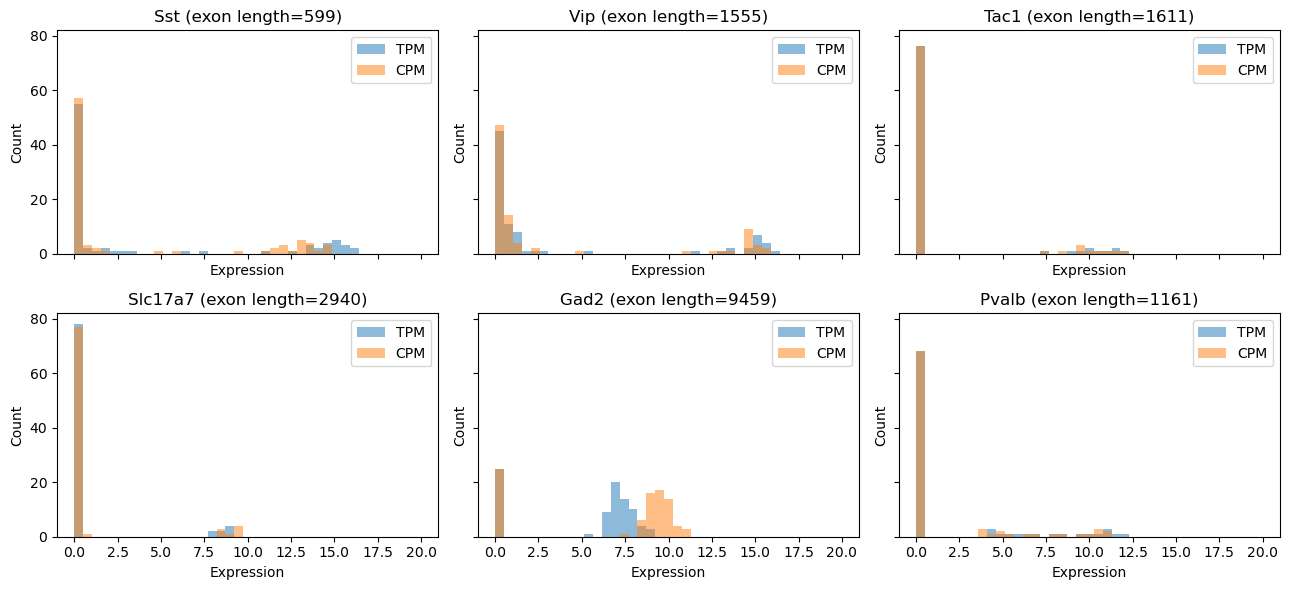

In [32]:
gene_name_list = ['Sst', 'Vip', 'Tac1', 'Slc17a7', 'Gad2', 'Pvalb']
fig, ax = plt.subplots(2, 3, figsize=(13,6), sharex=True, sharey=True)
for i in range(len(gene_name_list)):
    gene_name = gene_name_list[i]
    exon_length = gene_info_df.loc[gene_name, 'exon_length']
    ax[i//3, i%3].hist(tpm_median_per_mapping.loc[gene_name], bins=np.linspace(0,20,40), alpha=0.5, label='TPM');
    ax[i//3, i%3].hist(cpm_median_per_mapping.loc[gene_name], bins=np.linspace(0,20,40), alpha=0.5, label='CPM');
    # ax[i//3, i%3].hist(tpm_data.loc[gene_name]+1, bins=np.logspace(-2,7,100), alpha=0.5, label='TPM');
    # ax[i//3, i%3].hist(cpm_data.loc[gene_name]+1, bins=np.logspace(-2,7,100), alpha=0.5, label='CPM');
    # ax[i//3, i%3].hist(tpm_data.loc[gene_name], bins=np.logspace(-2,7,100), alpha=0.5, label='TPM');
    # ax[i//3, i%3].hist(cpm_data.loc[gene_name], bins=np.logspace(-2,7,100), alpha=0.5, label='CPM');
    ax[i//3, i%3].set_title(f'{gene_name} (exon length={exon_length})')
    ax[i//3, i%3].legend()
    # ax[i//3, i%3].set_xscale('log')
    ax[i//3, i%3].set_xlabel('Expression')
    ax[i//3, i%3].set_ylabel('Count')
fig.tight_layout()


## Testing threshold
- for later

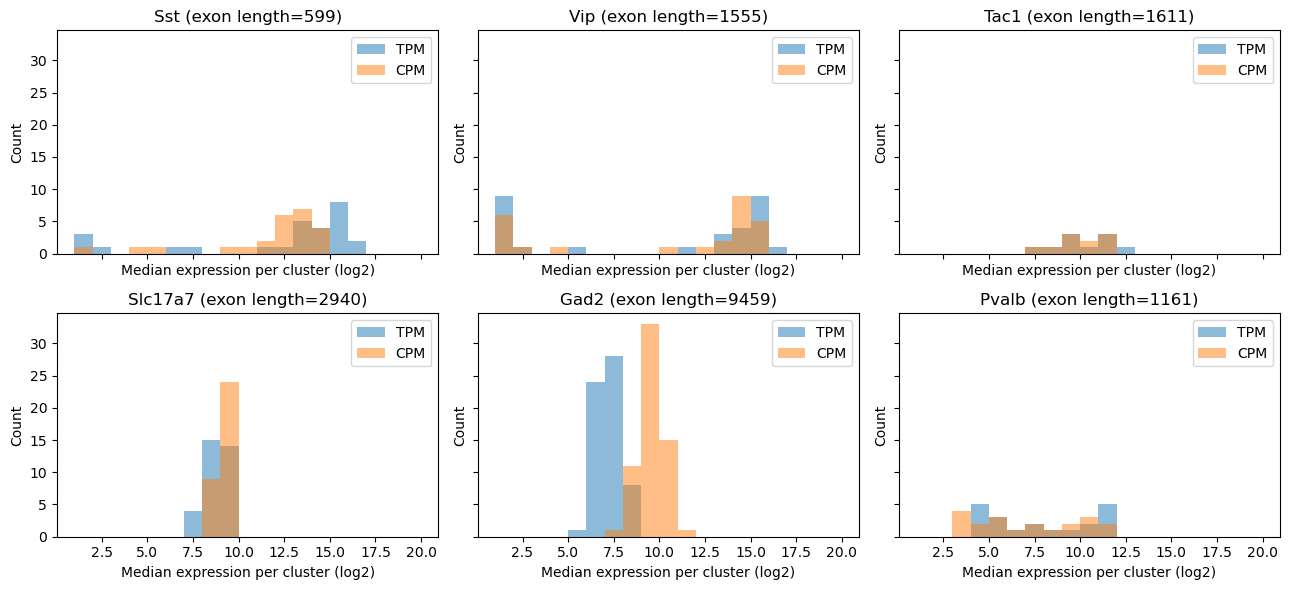

In [253]:
gene_name_list = ['Sst', 'Vip', 'Tac1', 'Slc17a7', 'Gad2', 'Pvalb']
fig, ax = plt.subplots(2, 3, figsize=(13,6), sharex=True, sharey=True)
for i in range(len(gene_name_list)):
    gene_name = gene_name_list[i]
    exon_length = gene_info_df.loc[gene_name, 'exon_length']
    # ax[i//3, i%3].hist(tpm_median_per_mapping.loc[gene_name], bins=np.linspace(0,20,40), alpha=0.5, label='TPM');
    # ax[i//3, i%3].hist(cpm_median_per_mapping.loc[gene_name], bins=np.linspace(0,20,40), alpha=0.5, label='CPM');
    ax[i//3, i%3].hist(tpm_median_per_mapping.loc[gene_name], bins=np.linspace(1,20,20), alpha=0.5, label='TPM');
    ax[i//3, i%3].hist(cpm_median_per_mapping.loc[gene_name], bins=np.linspace(1,20,20), alpha=0.5, label='CPM');
    ax[i//3, i%3].set_title(f'{gene_name} (exon length={exon_length})')
    ax[i//3, i%3].legend()
    ax[i//3, i%3].set_xlabel('Median expression per cluster (log2)')
    ax[i//3, i%3].set_ylabel('Count')
fig.tight_layout()

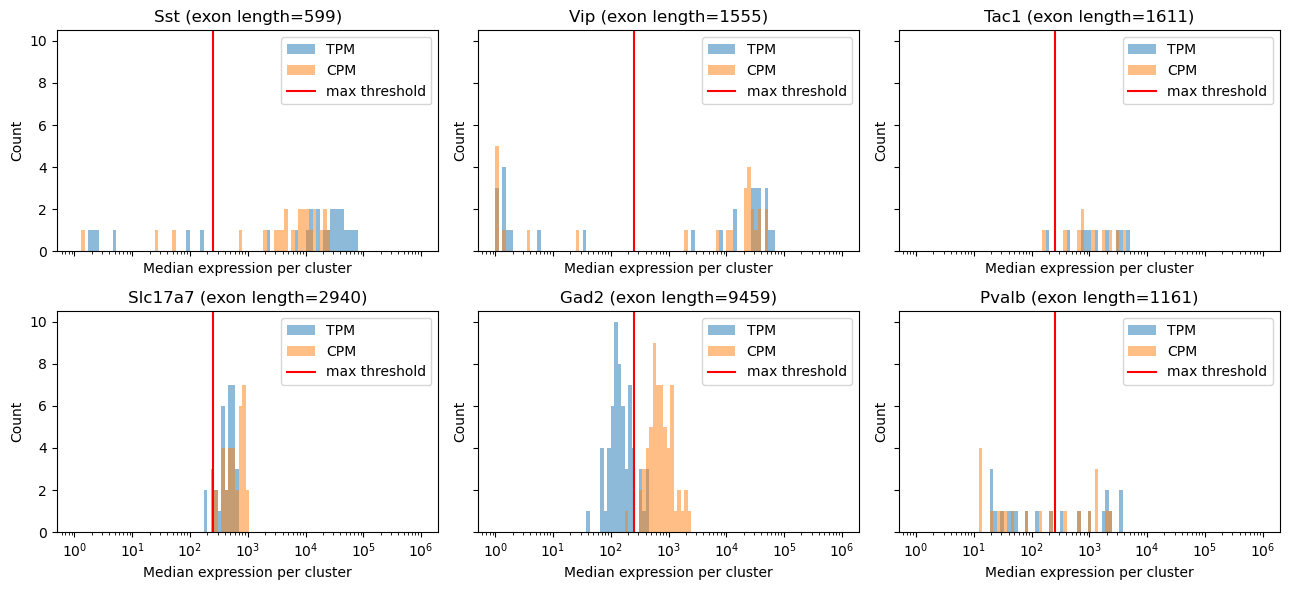

In [265]:
tpm_summary_data = 2**tpm_median_per_mapping - 1
cpm_summary_data = 2**cpm_median_per_mapping - 1
gene_name_list = ['Sst', 'Vip', 'Tac1', 'Slc17a7', 'Gad2', 'Pvalb']
fig, ax = plt.subplots(2, 3, figsize=(13,6), sharex=True, sharey=True)
for i in range(len(gene_name_list)):
    gene_name = gene_name_list[i]
    exon_length = gene_info_df.loc[gene_name, 'exon_length']
    # ax[i//3, i%3].hist(tpm_summary_data.loc[gene_name], alpha=0.5, label='TPM');
    # ax[i//3, i%3].hist(cpm_summary_data.loc[gene_name], alpha=0.5, label='CPM');
    ax[i//3, i%3].hist(tpm_summary_data.loc[gene_name], bins=np.logspace(0,6,100), alpha=0.5, label='TPM');
    ax[i//3, i%3].hist(cpm_summary_data.loc[gene_name], bins=np.logspace(0,6,100), alpha=0.5, label='CPM');
    ax[i//3, i%3].set_title(f'{gene_name} (exon length={exon_length})')
    ax[i//3, i%3].axvline(250, color='r', label='max threshold')
    ax[i//3, i%3].legend()
    ax[i//3, i%3].set_xscale('log')
    ax[i//3, i%3].set_xlabel('Median expression per cluster')
    ax[i//3, i%3].set_ylabel('Count')
fig.tight_layout()

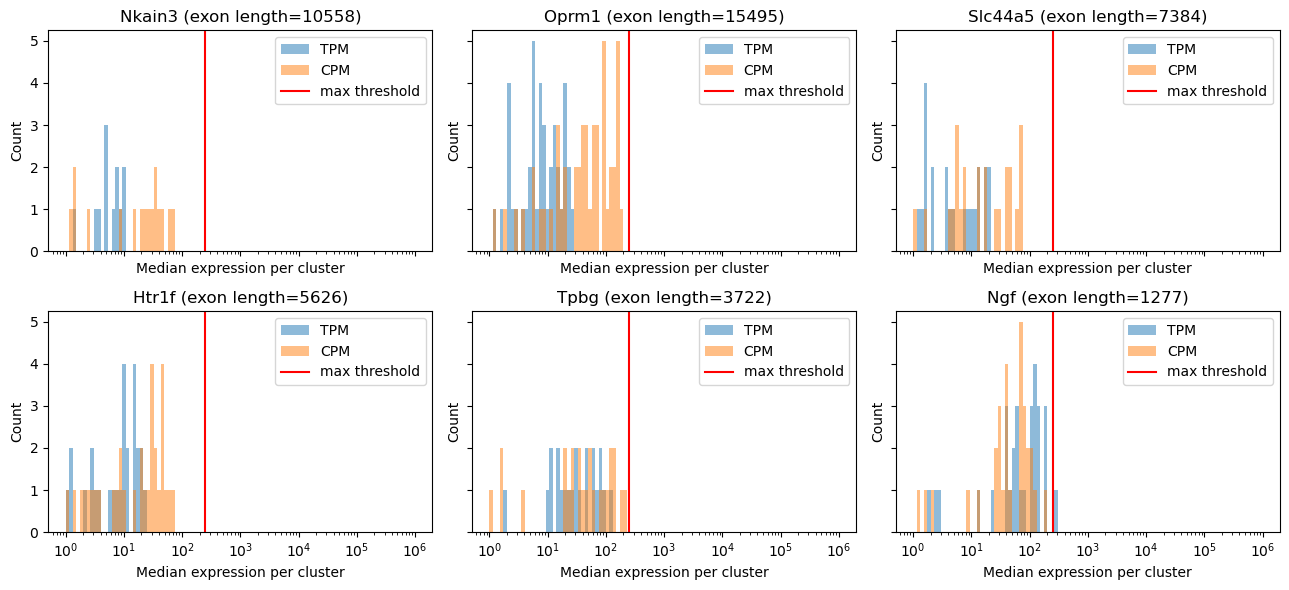

In [263]:
# For those selected from the previous run (with the default filtering parameters)
tpm_summary_data = 2**tpm_median_per_mapping - 1
cpm_summary_data = 2**cpm_median_per_mapping - 1
gene_name_list = ['Nkain3', 'Oprm1', 'Slc44a5', 'Htr1f', 'Tpbg', 'Ngf']
fig, ax = plt.subplots(2, 3, figsize=(13,6), sharex=True, sharey=True)
for i in range(len(gene_name_list)):
    gene_name = gene_name_list[i]
    exon_length = gene_info_df.loc[gene_name, 'exon_length']
    # ax[i//3, i%3].hist(tpm_summary_data.loc[gene_name], alpha=0.5, label='TPM');
    # ax[i//3, i%3].hist(cpm_summary_data.loc[gene_name], alpha=0.5, label='CPM');
    ax[i//3, i%3].hist(tpm_summary_data.loc[gene_name], bins=np.logspace(0,6,100), alpha=0.5, label='TPM');
    ax[i//3, i%3].hist(cpm_summary_data.loc[gene_name], bins=np.logspace(0,6,100), alpha=0.5, label='CPM');
    ax[i//3, i%3].set_title(f'{gene_name} (exon length={exon_length})')
    ax[i//3, i%3].axvline(250, color='r', label='max threshold')
    ax[i//3, i%3].legend()
    ax[i//3, i%3].set_xscale('log')
    ax[i//3, i%3].set_xlabel('Median expression per cluster')
    ax[i//3, i%3].set_ylabel('Count')
fig.tight_layout()

## Look for max off 

In [42]:
off_clusters=list(annotation.query('class_label=="Non-Neuronal"').mapping_label.unique())
tpm_summary_data = 2**tpm_median_per_mapping - 1
tpm_summary_data.loc[:, off_clusters].max(axis=1).sort_values(ascending=False)

gene
Ptgds       357098.515833
Cst3        156065.293088
Apoe         64220.199976
Crip1        41605.330238
Tmsb4x       33841.107592
                ...      
Gm33841          0.000000
Gm33843          0.000000
Gm33844          0.000000
Gm33845          0.000000
n-R5s149         0.000000
Length: 45768, dtype: float64

In [46]:
tpm_summary_data.shape

(45768, 86)

Text(0, 0.5, 'Max expression in off clusters')

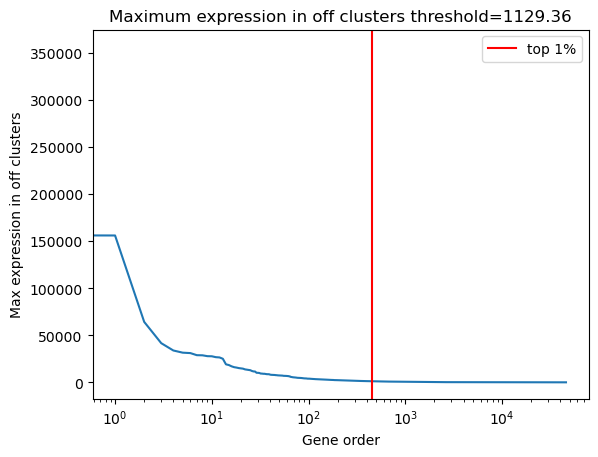

In [54]:
fig, ax = plt.subplots()
ax.plot(tpm_summary_data.loc[:, off_clusters].max(axis=1).sort_values(ascending=False).values)
ax.set_xscale('log')
ax.axvline(tpm_summary_data.shape[0]/100, color='r', label='top 1%')
ax.legend()
max_off_threshold = tpm_summary_data.loc[:, off_clusters].max(axis=1).sort_values(ascending=False).values[tpm_summary_data.shape[0]//100]
ax.set_title(f'Maximum expression in off clusters threshold={max_off_threshold:.2f}')
ax.set_xlabel('Gene order')
ax.set_ylabel('Max expression in off clusters')

## conclusion
- We can use tpm distribution with probe validation data (spot-countability) for thresholding
- For now use 5,000 as default for max_on (when using TPM)

In [305]:
reload(mfishtools)

<module 'mfishtools' from 'c:\\Users\\jinho.kim\\Github\\lamf_analysis_lims\\gene_panel_selection\\mfishtoolspy\\mfishtools.py'>

In [87]:
tpm_summary_data = 2**tpm_median_per_mapping - 1
run_genes, filtered_out_genes = \
    mfishtools.filter_panel_genes(tpm_summary_data,
                                  prop_expr=tpm_prop_expr_mapping,
                                  on_clusters=keep_mappings + other_mappings,
                                  starting_genes=ops['starting_genes'],
                                  off_clusters=list(annotation.query('class_label=="Non-Neuronal"').mapping_label.unique()),
                                  max_on=ops['max_on'],
                                  max_off=ops['max_off'])

1685 total genes pass constraints prior to binary score calculation.


In [315]:
mapping_to_group = annotation.loc[:, ['mapping_label', 'group_label']].drop_duplicates().set_index('mapping_label').loc[keep_mappings + other_mappings]

In [317]:
keep_ml_temp = np.random.choice(mapping_to_group.index.values, 30, replace=True)
keep_ml_temp

array(['GABAergic Lamp5 Lhx6', 'GABAergic Vip Lmo1 Myl1',
       'GABAergic Pvalb Reln Itm2a', 'GABAergic Vip Igfbp6 Pltp',
       'GABAergic Pvalb Reln Tac1', 'Glutamatergic L5 NP VISp Trhr Cpne7',
       'GABAergic Vip Arhgap36 Hmcn1', 'GABAergic Sst Hpse Sema3c',
       'GABAergic Vip Lect1 Oxtr', 'GABAergic Sst Tac1 Tacr3',
       'GABAergic Sst Chrna2 Glra3', 'GABAergic Vip Crispld2 Htr2c',
       'GABAergic Sst Myh8 Etv1 ', 'GABAergic Vip Crispld2 Kcne4',
       'Glutamatergic L5 PT VISp Lgr5', 'GABAergic Pvalb Calb1 Sst',
       'GABAergic Sst Rxfp1 Eya1', 'GABAergic Vip Crispld2 Kcne4',
       'GABAergic Sst Tac1 Tacr3', 'GABAergic Vip Lect1 Oxtr',
       'GABAergic Sst Chodl', 'GABAergic Pvalb Sema3e Kank4',
       'GABAergic Pvalb Tpbg', 'GABAergic Pvalb Reln Itm2a',
       'GABAergic Lamp5 Lsp1', 'GABAergic Serpinf1 Clrn1',
       'GABAergic Serpinf1 Clrn1', 'Glutamatergic L5 IT VISp Col27a1',
       'GABAergic Sncg Gpr50', 'GABAergic Sst Myh8 Fibin'], dtype=object)

In [333]:
annotation['group_label'].unique()

array(['GABAergic Pvalb Tpbg', 'Glutamatergic L4',
       'GABAergic Vip Chat Htr1f', 'Glutamatergic L2/3 IT',
       'GABAergic Lamp5 Lsp1', 'Glutamatergic L5 Glutamatergic',
       'GABAergic Sst Hpse Sema3c', 'GABAergic Vip Pygm C1ql1',
       'GABAergic Vip Ptprt Pkp2', 'nan', 'GABAergic Vip Igfbp4 Mab21l1',
       'Glutamatergic L6 CT', 'Glutamatergic L6 IT',
       'GABAergic Sst Chodl', 'GABAergic Lamp5 Ntn1 Npy2r',
       'GABAergic Vip Igfbp6 Car10', 'GABAergic Vip Crispld2 Kcne4',
       'GABAergic Vip Igfbp6 Pltp', 'GABAergic L5 GABAergic',
       'GABAergic Pvalb Reln Itm2a', 'GABAergic Vip Lmo1 Myl1',
       'GABAergic Vip Crispld2 Htr2c', 'GABAergic Lamp5 Plch2 Dock5',
       'GABAergic Vip Col15a1 Pde1a', 'GABAergic Vip Rspo4 Rxfp1 Chat',
       'GABAergic Lamp5 Fam19a1 Tmem182', 'GABAergic Lamp5 Fam19a1 Pax6',
       'GABAergic Vip Arhgap36 Hmcn1', 'GABAergic Sncg Vip Itih5',
       'GABAergic Lamp5 Lhx6', 'GABAergic Sncg Slc17a8',
       'GABAergic Sncg Vip Nptx2', 'GA

In [35]:
all_groups = keep_groups + other_groups
annotation.query('group_label in @all_groups').groupby('group_label').size().sort_values(ascending=True)

group_label
GABAergic Sncg Slc17a8               12
GABAergic Serpinf1 Aqp5 Vip          17
GABAergic Sst Calb2 Necab1           27
GABAergic Sncg Gpr50                 28
GABAergic Vip Col15a1 Pde1a          30
GABAergic Sst Hpse Cbln4             36
GABAergic Sncg Vip Nptx2             39
GABAergic Lamp5 Krt73                41
GABAergic Sst Mme Fam114a1           42
GABAergic Lamp5 Fam19a1 Pax6         43
GABAergic Sncg Vip Itih5             46
GABAergic Lamp5 Fam19a1 Tmem182      46
GABAergic Pvalb Vipr2                46
GABAergic Lamp5 Lhx6                 46
GABAergic Vip Rspo1 Itga4            50
GABAergic Pvalb Reln Itm2a           58
GABAergic Vip Igfbp4 Mab21l1         58
GABAergic Sst Tac1 Tacr3             59
GABAergic Vip Rspo4 Rxfp1 Chat       67
GABAergic Vip Lmo1 Myl1              68
GABAergic Vip Igfbp6 Car10           71
GABAergic Sst Chodl                  85
GABAergic Sst Tac1 Htr1d             95
GABAergic Vip Crispld2 Kcne4        110
GABAergic Vip Lect1 Oxtr    

In [90]:
reload(mfishtools)
# Takes 1 hour for adding 12 genes (from 500 candidates)
run_mappings = keep_mappings + other_mappings
keep_samples = annotation[annotation['mapping_label'].isin(run_mappings)].index.values

built_panel, metric = mfishtools.build_mapping_based_marker_panel_testing(
    map_data=tpm_log2.loc[run_genes, keep_samples],
    mapping_median_data=tpm_median_per_mapping.loc[run_genes, run_mappings],
    mapping_call=annotation.loc[keep_samples, 'mapping_label'],
    mapping_to_group=annotation.loc[keep_samples, ['mapping_label','group_label']].drop_duplicates().set_index('mapping_label').loc[run_mappings]['group_label'],
    group_median_data=tpm_median_per_group.loc[run_genes, keep_groups + other_groups],
    panel_size=ops['full_panel_size'],
    num_subsample=ops['num_subsample'],
    current_panel=ops['starting_genes'].copy(),
)

c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Cxcl14 with average cluster distance 0.147 [16].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Cplx3 with average cluster distance 0.134 [17].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Zbtb20 with average cluster distance 0.124 [18].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Hopx with average cluster distance 0.117 [19].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Cd24a with average cluster distance 0.113 [20].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Shisa8 with average cluster distance 0.107 [21].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Plxdc2 with average cluster distance 0.103 [22].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Sema3e with average cluster distance 0.101 [23].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Reln with average cluster distance 0.097 [24].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Popdc3 with average cluster distance 0.095 [25].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Caln1 with average cluster distance 0.091 [26].


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 24.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Added Ramp1 with average cluster distance 0.089 [27].


# Save the panel and option

In [93]:

now = datetime.datetime.now()
date = now.strftime("%Y_%m_%d")

save_ops_fn_base = f'ops_{date}_*.json'
save_results_fn_base = f'results_{date}_*.json'

prev_ops_fn_list = glob(str(output_folder / save_ops_fn_base))
prev_results_fn_list = glob(str(output_folder / save_results_fn_base))

if (len(prev_ops_fn_list) == 0) and (len(prev_results_fn_list) == 0):
    max_prev_num = -1
else:
    max_prev_num = max([int(fn.split('.')[0].split('_')[-1]) for fn in prev_ops_fn_list] +
                        [int(fn.split('.')[0].split('_')[-1]) for fn in prev_results_fn_list])
curr_num = max_prev_num + 1

save_ops_fn = output_folder / f'ops_{date}_{curr_num:02}.json'
save_results_fn = output_folder / f'results_{date}_{curr_num:02}.json'

results = {'run_genes': run_genes,
           'built_panel': built_panel,
           'metric': metric}


with open(save_ops_fn, 'w') as f:
    json.dump(ops, f)
with open(save_results_fn, 'w') as f:
    json.dump(results, f)

# Look at the performance

In [95]:
list(output_folder.glob('results_*.json'))

[WindowsPath('//allen/programs/mindscope/workgroups/learning/jinho/gene_panel_selection/results/results_2024_10_21_00.json'),
 WindowsPath('//allen/programs/mindscope/workgroups/learning/jinho/gene_panel_selection/results/results_2024_10_22_00.json'),
 WindowsPath('//allen/programs/mindscope/workgroups/learning/jinho/gene_panel_selection/results/results_2024_10_22_01.json')]

In [98]:
ops_fn_list = list(output_folder.glob('ops_*.json'))
ops_fn_gabaergic = []
ops_gabaergic = []
results_gabaergic = []
for ops_fn in ops_fn_list:
    with open(ops_fn, 'r') as f:
        ops = json.load(f)
    if 'GABAergic' in ops['panel_name']:
        ops_fn_gabaergic.append(ops_fn)
        ops_gabaergic.append(ops)
        results_fn = ops_fn.name.replace('ops', 'results')
        with open(output_folder / results_fn, 'r') as f:
            results_gabaergic.append(json.load(f))
    

In [99]:
print(len(results_gabaergic))

2


In [100]:
result_i = 0
results = results_gabaergic[result_i]

In [102]:
results.keys()

dict_keys(['run_genes', 'built_panel', 'metric'])

In [60]:
built_panel

['Gad2',
 'Slc17a7',
 'Pvalb',
 'Sst',
 'Vip',
 'Cck',
 'Tac1',
 'Npy',
 'Crh',
 'Necab1',
 'Ptprt',
 'Kirrel3',
 'Penk',
 'Hpse',
 'Calb2',
 'Chodl',
 'Cxcl14',
 'Pcdh8',
 'Npas1',
 'Ramp1',
 'Cplx3',
 'Slc5a5',
 'Thsd7a',
 'Lin7a',
 'Npy2r',
 'Rxfp1',
 'Tcerg1l',
 'Parm1']

In [545]:
map_data=tpm_log2.loc[run_genes, keep_samples]
mapping_median_data=tpm_median_per_mapping.loc[run_genes, run_mappings]
mapping_call=annotation.loc[keep_samples, 'mapping_label']
mapping_to_group=annotation.loc[keep_samples, ['mapping_label','group_label']].drop_duplicates().set_index('mapping_label').loc[run_mappings]['group_label']
group_median_data=tpm_median_per_group.loc[run_genes, keep_groups + other_groups]
panel_size=ops['full_panel_size']
num_subsample=50
current_panel=ops['starting_genes']

In [546]:
cor_dist = lambda x: 1 - np.corrcoef(x)
if cluster_genes is None:
    cluster_genes = group_median_data.index
cluster_genes = list(set(cluster_genes).intersection(set(group_median_data.index)))
group_distance = pd.DataFrame(cor_dist(group_median_data.loc[cluster_genes, :].T),
                                index=group_median_data.columns, columns=group_median_data.columns)
max_group_distance = group_distance.values.max()
if na_str not in group_distance.columns:
    group_distance[na_str] = max_group_distance

In [547]:
na_str='None'
if na_str not in mapping_to_group.index.values:
    mapping_to_group[na_str] = na_str # to handle missing values after get_top_match

In [548]:
group_call = mapping_call.map(mapping_to_group)

In [552]:
seed = None
corr_mapping = True
from dask import delayed, compute
from dask.distributed import Client
num_iter_each_addition = 100
client = Client()
tasks = [delayed(mfishtools._run_one_iter_parallel)(map_data, group_call, mapping_call, num_subsample, 
                                        seed, mapping_median_data, other_genes, current_panel, 
                                        group_distance, mapping_to_group, corr_mapping, 
                                        na_str=na_str) for iter_num in range(num_iter_each_addition)]
results = compute(*tasks, num_workers=dask.system.cpu_count()-1)
client.close()


c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64898 instead
  warnings.warn(
c:\Users\jinho.kim\Anaconda3\envs\mfish\lib\site-packages\distributed\client.py:3362: UserWarning: Sending large graph of size 41.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [557]:
match_count = np.stack(results)
mean_match_count = np.mean(match_count, axis=0)
wm = np.argmax(mean_match_count)
gene_to_add = other_genes[wm]

In [558]:
gene_to_add

'Cxcl14'

In [559]:
mean_match_count[wm]

-0.11108676680860852

In [560]:
wm

356

In [562]:
len(mean_match_count)

494